# Project 1: High dimensional data

## Introduction
The aim of this notebook is to show and apply three different techniques for dimensionality reduction of data that we want to classify with a quantum circuit. This is important, since nowadays NISQ devices can count on 50-100 noisy qubits at most. Therefore, encoding 1 dimension to 1 qubit is often unfeasible.

Here we will be using the Winsconsin Breast Cancer dataset, which has the following features (see [sklearn.datasets.load_breast_cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer))

|||
|---------|---|
| Classes | 2 |
| Samples per class | 212 (M), 357 (B) |
| Samples total | 569 |
| Dimensionality | 30 |
| Features | real, positive |

In Part 1 of this notebook, we will reduce dimensions using principal component analysis (PCA) and then use the method of [Havlicek et al.](https://arxiv.org/abs/1804.11326). Here, one dimension of the reduced dataset will be encoded in 1 qubit. In Part 2, we will perform data dimensionality and classification together, by using the data re-uploading technique of [Perez-Salinas et al.](https://arxiv.org/abs/1907.02085). Finally, Part 3 will use amplitude encoding as shown in [Mottonen et al.](https://arxiv.org/abs/quant-ph/0407010) to exponentially reduce dimensionality, by encoding data in a quantum state.

Each technique will be first tested with a single split of the entire dataset in test/train subsets. Subsequently, each method will be benchmarked using 10-fold cross validation.

## Dimensionality reduction with PCA
### Finding the minimum number of principal components
Principal component analysis consists in projecting the original dataset $\{x^{(i)} \in \mathcal{R}^d,\; i=1,\dots N\}$ into a lower-dimensional subspace $R^{d\prime}$ with $d\prime < d$. The basis of this new subspace is given by the directions of maximum variance of the dataset, with the constraint of being orthogonal to each other.

It follows that the principal components of the dataset correspond to the eigenvectors $v_i$ of the covariance matrix of the dataset $\mathcal{X}$, associated to the largest eigenvalues $\lambda_i$.

Once the eigencouples $(\lambda_i,\, v_i)$ are found, they can be sorted in decreasing order, depending on $\lambda_i$. The relative importance of each eigenvalue is given by the *variance explained ratio*, that is
$$
r_j = \frac{\lambda_j}{\sum_{i=1}^d \lambda_i}.
$$
We can then study the cumulative sum of the variance explained ratios, i.e.
$$
\text{cumsum}(i) = \frac{\sum_{j<i}\lambda_j}{\sum_{i=1}^d \lambda_i} = \sum_{j<i}r_j.
$$
This quantity will tell us the minimum number of principal components that we should consider to still preserve the variance of the original dataset up to a certain accuracy.

The covariance matrix, its eigencouples and the cumulative sum of the eigenvalues are computed in the next few cells. The code follows the steps illustrated in [this webpage](https://towardsdatascience.com/principal-component-analysis-for-dimensionality-reduction-115a3d157bad).

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
# Load data
data = load_breast_cancer()
X = data.data
Y = data.target

Operations such as data scaling or computing the covariance matrix require to extract information from data such as mean and std. dev.

In classification, our entire dataset is split into a training and a testing subset. The aim is to learn the model from the training set and validate the trained model with unseen data from the test set.

Therefore, to keep the validation unbiased, scaling, derivation of the covariance matrix, etc are done only on the training subset $X_{train}$.

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0, stratify=Y)

The `sklearn` package offers the `StandardScaler` class, which allows to scale the training set with the `fit_transform` method as so
$$
x_{sc} = \frac{x - \mu}{\sigma},
$$
where  $\mu$ and $\sigma$ are mean and standard deviation of the training set. These two quantities are kept to scale the test set with the `transform` method.

In [5]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_train)

The covariance matrix $\Sigma \in R^{d\times d}$ is expressed, in components terms as
$$
\Sigma_{jk}=\frac{1}{N}\sum_{i=1}^N (x_j^{(i)} - \mu_j) (x_k^{(i)} - \mu_k),
$$
where $x_j^{(i)}$ is the $j^{th}$ feature of the $i^{\text{th}}$ data-point and $\mu_j$ is the statisticl mean.

Numpy offers the methods `np.cov` to compute $\Sigma$ and `np.eigs` for numerically estimating the eigencouples of a matrix.

In [6]:
cov_mat = np.cov(X_train_sc.T)
eigvals_cov, eigvecs_cov = np.linalg.eig(cov_mat)

Now, we can first compute the variance explained ratios and sort them in decreasing order. As a second step, we can compute the cumulative sums and finally plot both quantities to see the individual contributions of the eigenvalues and the number of principal components that we want to consider.

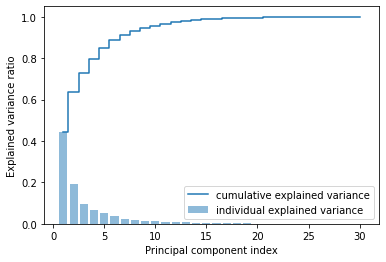

In [7]:
tot = sum(eigvals_cov)
var_expl_ratios = [(l / tot) for l in sorted(eigvals_cov, reverse=True)]

cum_sum_expl_ratios = np.cumsum(var_expl_ratios)

# plot explained variances
plt.bar(range(1,31), var_expl_ratios, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(1,31), cum_sum_expl_ratios, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

From the plot, we see that keeping 5 components preserves around 85\% of the original variance.

### Projecting data onto the principal components
As a last step for dimensionality reduction, we need to use the components the we intend to keep to build the projection matrix $W \in R^{d\prime\times d}$, such that
$$
X^\prime = W\, X,
$$
where $X \in R^{N\times d}$ is the matrix of the non-reduced datapoints and $X \in R^{N\times d\prime}$ is the one after reduction.

In [11]:
N_PRINC_COMP = 5

# Make a list of (eigenvalue, eigenvector) tuples
eigenpairs_cov = [(np.abs(eigvals_cov[i]), eigvecs_cov[:, i]) for i in range(len(eigvals_cov))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigenpairs_cov.sort(key=lambda k: k[0], reverse=True)

# Build the projection matrix
W = np.hstack([eigenpairs_cov[i][1][:, np.newaxis] for i in range(N_PRINC_COMP)])

# print('Matrix W:\n', W)

In [12]:
# Project the training subset onto the reduced subspace
X_train_pca = X_train_sc.dot(W)

### Quantum variational circuit for classification
One method of doing supervised learning with a quantum circuit is to use a variational quantum classifier as proposed by [Havicek et al.](https://arxiv.org/abs/1804.11326), [Fahri et al.](https://arxiv.org/abs/1802.06002) and [Schuld et al.](https://arxiv.org/abs/1804.00633).

The quantum circuit architecture consists of three parts
1. Feature-map circuit. This allows to encode the data into a quantum state. In this first example, we use one qubit per data feature and encode these as angles of rotational quantum gates
2. Variational circuit. The part of the overall circuit that depends on the trainable parameters. 
3. Measurement.

#### Feature-map circuit
A feature map is a function $\Phi$ which maps the data to a higher dimensional space. The aim of this transformation is to ensure that data will be linearly separable, once mapped in the higher-dimensional feature space.

In this case we choose
$$
\Phi(x) = \bigotimes_{j=1}^n U(\phi_j)
$$
with $\phi_j=x_j$ (one angle per qubit/feature) and
$$
U(\phi_j) = R_Z(\phi_j)\, R_Y(\phi_j)\, R_Z(\phi_j),
$$
which is the tensor-product feature map proposed in the supplemental material of [Havicek et al.](https://arxiv.org/abs/1804.11326).

First, we declare a number of qubits equal to the number of principal components that we kept from the reduction with PCA (5). Also we initialize a register of qubits using `cirq` and a simulator.

In [13]:
import cirq

In [14]:
n_qubits = 5

# Create a register of qubits
qubits = cirq.LineQubit.range(n_qubits)   

# Initialize simulator
simulator = cirq.Simulator()


In [15]:
def feature_map_circuit(x_i):
    """Add the feature map part of the variational quantum circuit

    Args:
        x_i (np.ndarray): array of a single data-point
    """
    yield (cirq.ops.rz(x_i[j]).on(qubits[j]) for j in range(len(x_i)))
    yield (cirq.ops.ry(x_i[j]).on(qubits[j]) for j in range(len(x_i)))
    yield (cirq.ops.rz(x_i[j]).on(qubits[j]) for j in range(len(x_i)))

In [18]:
print(cirq.Circuit(feature_map_circuit(X_train_pca[0,:])))

0: ───Rz(-1.01π)────Ry(-1.01π)────Rz(-1.01π)────

1: ───Rz(-0.385π)───Ry(-0.385π)───Rz(-0.385π)───

2: ───Rz(-0.093π)───Ry(-0.093π)───Rz(-0.093π)───

3: ───Rz(0.291π)────Ry(0.291π)────Rz(0.291π)────

4: ───Rz(0.313π)────Ry(0.313π)────Rz(0.313π)────


#### Variational circuit
The variational part of a quantum classifier consists of a basic block of parametrized single qubit gates and entangling gates, which is repeated for $L$ layers. The gates used form a universal set.

The additional layers can be interpreted in two ways. On one hand, each layer is the analogous of a neuron in a hidden layer of a classical neural network ([Perez-Salinas et al](https://arxiv.org/abs/1907.02085)). On the other hand, having a universal set of gates, repeating a basic block for $L$ 'time-slices' allows to reproduce every matrix exponential, i.e. every unitary. This is ensured by the Suzuki-Trotter formula.

In our case, the single-qubit parametrized gates consist of $R_X(\theta)$ gates and the entangling gates are controlled-$Z$ gates.

For the time being, let's fix a number of layers. We will then do a sensitivity analysis for this hyperparameter.

In [16]:
# Number of layers
n_layers = 3

In [22]:
def variational_circuit(thetas):
    """Generate the parametrized part of the variational quantum classifier

    Args:
        thetas (np.ndarray): 2-dimensional array. The first dimension corresponds to the number of features and the second one to the number of layers.
    """
    for l in range(n_layers):
        yield (cirq.ops.rx(thetas[l][j]).on(qubits[j]) for j in range(n_qubits))
        yield (cirq.ops.CZ(qubits[j], qubits[j+1]) for j in range (n_qubits-1))
        yield cirq.ops.CZ(qubits[0], qubits[-1])


Let's now create a random matrix of parameters to see if the variational circuit looks as expected.

In [24]:
np.random.seed(13)
theta0 = np.random.uniform(-2*np.pi, 2*np.pi, size=(n_layers, n_qubits))

variational_circuit_init = cirq.Circuit(variational_circuit(theta0))
print(variational_circuit_init.to_text_diagram(transpose=True))

  0           1           2          3          4
  │           │           │          │          │
  Rx(1.11π)   Rx(-1.05π)  Rx(1.3π)   Rx(1.86π)  Rx(1.89π)
  │           │           │          │          │
  @───────────@           │          │          │
  │           │           │          │          │
  │           @───────────@          │          │
  │           │           │          │          │
  │           Rx(0.436π)  @──────────@          │
  │           │           │          │          │
  │           │           Rx(1.1π)   @──────────@
  │           │           │          │          │
┌╴│           │           │          │          │          ╶┐
│ @───────────┼───────────┼──────────┼──────────@           │
│ │           │           │          Rx(0.566π) │           │
└╴│           │           │          │          │          ╶┘
  │           │           │          │          │
  Rx(-0.186π) │           │          │          Rx(0.888π)
  │           │           │        